In [161]:
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [193]:
RANDOM_SEED = 42
BATCH_SIZE = 512
# EPOCHS = 50 # changed to 15 down by the actual training function
LEARNING_RATE = 0.0001
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
# ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4 #encoders in rel life are stacked multiple times
EMBED_DIM = (PATCH_SIZE * PATCH_SIZE) * IN_CHANNELS # 16 = H*W * Channels
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49 = (HWC//Size)^2

#stuff I don't yet understand
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

## Create Image Patches, Convert to Embeddings, CLS Token Classification


In [163]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) # -1, -1 do not modify dim

        x = self.patcher(x).permute(0, 2, 1)# image reshape 
        x = torch.cat([cls_token, x], dim=1) #merge cls_tok w/ patches
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device) #dummy input for checking work. BATCH_SIZE, INPUT_CHANNELS, IMG_HEIGHT, IMG_WIDTH
print(model(x).shape) # model weights, layers and  
### 512 - BATCH SIZE , 50 tokens => 49 patches as tokens + 1 cls token, 16 - Size of Patches

torch.Size([512, 50, 16])


## Building Vision Transformer Model (on top of Patches Class)


In [164]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[: , 0 , :]) #mlp head needs to take token only
        # REMEBER THAT THE CLS TOKEN AT POSN 0 IS A LEARNABLE Feature and its value is influenced by every other (token+img) combo in the "list".
        # one more layer, a softmax output perhaps? GPT/instructor: Activation fn is for inference not for training, we want to preserve raw logits everywhere else. I was assuming inference too early on.
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE, NUM_CLASSES

torch.Size([512, 10])


c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [165]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        #pretend the pass is for one single patch, each patch will be fed in one at a time for a given image. 
        self.Patch_Embedding 
        self.Linear = nn.Linear(16,16) #flatten input patch = 4*4 image
        #attach position encoding(which I think is just 1, 2, 3. . .)
        
        self.SelfAttention
        # self attention = iterate through list of patches to create vector of sim_score btwn patches. 
        # Input Embedding (e.g. Word Emb) -> Positional Encoding -> Self-Attention Layer -> Output
        #  **(** Normalise(Output + Input Embedding) -> FF Layer (2 FC Layers) -> Normalise(Output + Input$_{2}$ ) **) * N**

## Vision Transformer Implementation

#### Implementing ViT from Scratch


In [166]:
#@title ViT Implementation. Source: [Implementing Vision Transformer (ViT) from Scratch](https://medium.com/data-science/implementing-vision-transformer-vit-from-scratch-3e192c6155f0)
import math
import torch
from torch import nn


class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))


class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Create a learnable [CLS] token
        # Similar to BERT, the [CLS] token is added to the beginning of the input sequence
        # and is used to classify the entire sequence
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        # Create position embeddings for the [CLS] token and the patch embeddings
        # Add 1 to the sequence length for the [CLS] token
        self.position_embeddings = \
            nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Expand the [CLS] token to the batch size
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Concatenate the [CLS] token to the beginning of the input sequence
        # This results in a sequence length of (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


class AttentionHead(nn.Module):
    """
    A single attention head.
    This module is used in the MultiHeadAttention module.

    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size
        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        # The same input is used to generate the query, key, and value,
        # so it's usually called self-attention.
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, attention_head_size)
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return (attention_output, attention_probs)


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module.
    This module is used in the TransformerEncoder module.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a list of attention heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
            head = AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config["attention_probs_dropout_prob"],
                self.qkv_bias
            )
            self.heads.append(head)
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each attention head
        attention_outputs = [head(x) for head in self.heads]
        # Concatenate the attention outputs from each attention head
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)
        # Project the concatenated attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)


class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with some optimizations.
    All the heads are processed simultaneously with merged query, key, and value projections.
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # The attention head size is the hidden size divided by the number of attention heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        # Whether or not to use bias in the query, key, and value projection layers
        self.qkv_bias = config["qkv_bias"]
        # Create a linear layer to project the query, key, and value
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=self.qkv_bias)
        self.attn_dropout = nn.Dropout(config["attention_probs_dropout_prob"])
        # Create a linear layer to project the attention output back to the hidden size
        # In most cases, all_head_size and hidden_size are the same
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x, output_attentions=False):
        # Project the query, key, and value
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, all_head_size * 3)
        qkv = self.qkv_projection(x)
        # Split the projected query, key, and value into query, key, and value
        # (batch_size, sequence_length, all_head_size * 3) -> (batch_size, sequence_length, all_head_size)
        query, key, value = torch.chunk(qkv, 3, dim=-1)
        # Resize the query, key, and value to (batch_size, num_attention_heads, sequence_length, attention_head_size)
        batch_size, sequence_length, _ = query.size()
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        # Calculate the attention scores
        # softmax(Q*K.T/sqrt(head_size))*V
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)
        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        # Resize the attention output
        # from (batch_size, num_attention_heads, sequence_length, attention_head_size)
        # To (batch_size, sequence_length, all_head_size)
        attention_output = attention_output.transpose(1, 2) \
                                           .contiguous() \
                                           .view(batch_size, sequence_length, self.all_head_size)
        # Project the attention output back to the hidden size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            return (attention_output, attention_probs)


class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, config):
        super().__init__()
        self.use_faster_attention = config.get("use_faster_attention", False)
        if self.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x, output_attentions=False):
        # Self-attention
        attention_output, attention_probs = \
            self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        # Skip connection
        x = x + attention_output
        # Feed-forward network
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output
        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)


class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, config):
        super().__init__()
        # Create a list of transformer blocks
        self.blocks = nn.ModuleList([])
        for _ in range(config["num_hidden_layers"]):
            block = Block(config)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)


class ViTForClassfication(nn.Module):
    """
    The ViT model for classification.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        self.num_classes = config["num_classes"]
        # Create the embedding module
        self.embedding = Embeddings(config)
        # Create the transformer encoder module
        self.encoder = Encoder(config)
        # Create a linear layer to project the encoder's output to the number of classes
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)
        # Initialize the weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config["initializer_range"])
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config["initializer_range"],
            ).to(module.cls_token.dtype)

## Training Preparation

#### ViT from Scratch Article


In [231]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [232]:

batch_size = 64
# Create data loader for the training dataset
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [169]:
from matplotlib import pyplot as plt
# Function to visualize images
def show_images_with_labels(images, labels):
    fig, axes = plt.subplots(len(images)//5, 5, figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Value: {label}')
        ax.axis('off')
    plt.show()

# Get a batch of images from the training data loader
data_iter = iter(train_loader)
pictures, true_values = next(data_iter)

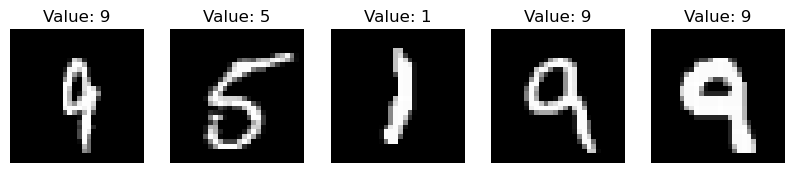

In [170]:
show_images_with_labels(pictures[10:15], true_values[10:15])

<class 'torch.Tensor'> torch.Size([1, 28, 28])


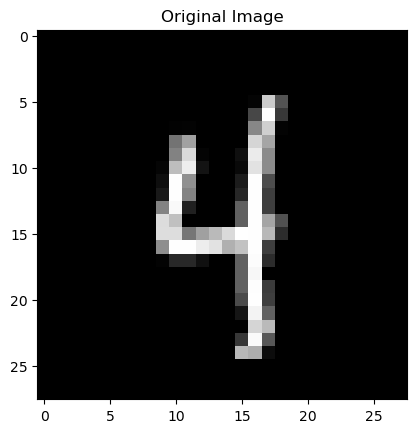

n_patches = 49. 7 rows and 7 columns.


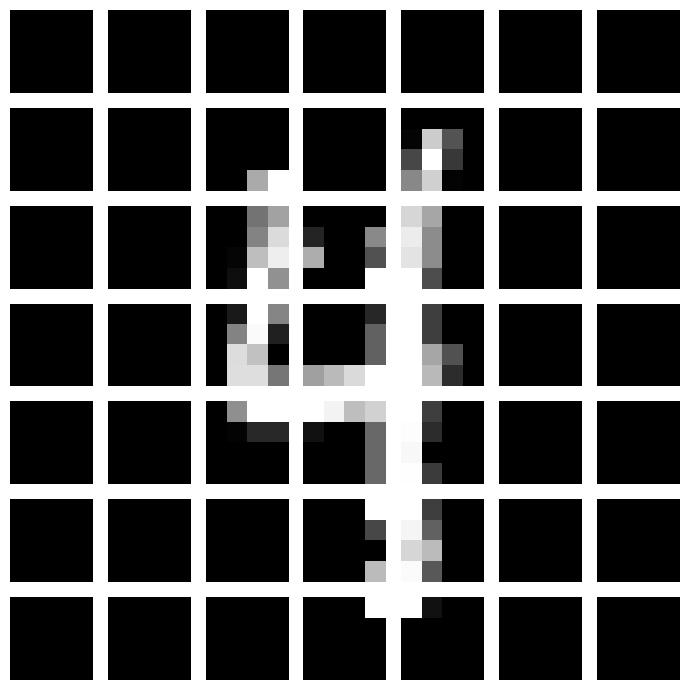

In [171]:
split_image = pictures[0]
# split = #picture is a tensor split into 4 patches (get size of one side, split)
# print(split_image.shape) #torch.Size([1, 28, 28])
print(type(split_image), split_image.shape)

# tensor_image = split_image.view(split_image.shape[1], split_image.shape[2], split_image.shape[0])
# plt.imshow(split_image.permute(1, 2, 0))# same as shaping with view()
# plt.show()
# print("shaped img: ",type(tensor_image), tensor_image.shape)

plt.title("Original Image")
plt.imshow(split_image.squeeze(), cmap='gray')
plt.show()

# def split_into_four(img: Tensor) -> List[Tensor]:
#     C, H, W = img.shape

#     assert H % 2 == 0 and W % 2 == 0 #"Height and Width must be even numbers."
#     top, bottom = torch.split(img, H // 2, dim=1)
#     top_left, top_right = torch.split(top, W // 2, dim=2)
#     bottom_left, bottom_right = torch.split(bottom, W // 2, dim=2)

#     return [top_left, top_right, bottom_left, bottom_right]

# split_image = split_into_four(split_image)

def patch_generator(img: Tensor, patch_size: int) -> List[Tensor]: 
    Img_channel, Img_Height, Img_Width = img.shape 
    
    unfold = nn.Unfold(kernel_size=(patch_size,patch_size), stride=(patch_size,patch_size)) #could stride be patch_size*patch_size
    patches = unfold(img.unsqueeze(0))
    patches = patches.squeeze(0).T #GPT line, not exactly sure the purpose of T?
    patches = patches.view(-1, Img_channel, patch_size, patch_size)
    return list(patches)

patches = patch_generator(split_image, patch_size=4) #PATCH_SIZE not defined yet

def show_image(patches, original_img_size, patch_size):  
    n_patches = len(patches)
    cols = rows = original_img_size // patch_size
    print(f"n_patches = {n_patches}. {rows} rows and {cols} columns.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    axes = axes.flatten() #GPT line
    for img, ax in zip(patches, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
    
    # Hide any leftover axes
    for ax in axes[n_patches:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_image(patches, 28, 4)

In [172]:
#@title Prepare Data 📊
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split 


def prepare_data(batch_size=4, num_workers=2):
    train_transform = transforms.Compose(
        [transforms.ToTensor(),
        # transforms.Resize((32, 32)),
        # transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5,), (0.5,))])

    # trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=train_transform)
    
    
    
    # Randomly sample a subset of the training set
    indices = torch.randperm(len(train_dataset))[:]
    
    train_dataset, val_dataset = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)
    
    train_dataset = torch.utils.data.Subset(train_dataset, indices)


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)



    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        # transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5,))])

    # testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=test_transform) 
    
    
    # Randomly sample a subset of the test set
    indices = torch.randperm(len(test_dataset))[:]
    test_dataset = torch.utils.data.Subset(test_dataset, indices)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ('0','1','2','3','4','5','6','7','8','9')
    return train_loader, val_loader, test_loader, classes

In [ ]:
# train_loader, val_loader, test_loader, classes = prepare_data(batch_size=BATCH_SIZE, num_workers=2)


In [174]:
dataIter = iter(train_loader)


In [ ]:
# pictures = next(dataIter)

TypeError: Caught TypeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: tensor(19854)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\torch\utils\data\dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\torch\utils\data\dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\pandas\core\frame.py", line 4102, in __getitem__
    indexer = self.columns.get_loc(key)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\pandas\core\indexes\base.py", line 3809, in get_loc
    and any(isinstance(x, slice) for x in casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Joshua\anaconda3\envs\MLI\Lib\site-packages\torch\_tensor.py", line 1154, in __iter__
    raise TypeError("iteration over a 0-d tensor")
TypeError: iteration over a 0-d tensor


In [177]:
def show_images_from_dataLoader(images, labels):
    fig, axes = plt.subplots(len(images)//5, 5, figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Value: {label}')
        ax.axis('off')
    plt.show()

In [178]:
# show_images_from_dataLoader(pictures[50:55], labels[50:55])
# show_images_from_dataLoader(pictures[50:55])

TypeError: show_images_from_dataLoader() missing 1 required positional argument: 'labels'

In [179]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

### Train Classes


In [184]:
class MNISTTrain(Dataset):
#since this is a pytorch dataset we definitely need init, len, and getitem
    def __init__(self, images, labels, indices):
        self.images = images # the pixel data (e.g., from your train_df).
        self.labels = labels # the ground truth labels (0–9).
        self.indices = indices # which rows of the dataframe to use
        
        
        #define the transformations we want to apply to the images
        self.transforms = transforms.Compose([
            transforms.ToPILImage(), #	Convert tensor into a PIL Image so we can apply image transformations like rotation.
            # transforms.RandomRotation(15), #Randomly rotate the image by up to ±15 degrees 
            transforms.ToTensor(), # 	Convert back from PIL Image to a PyTorch Tensor
            transforms.Normalize([0.5], [0.5]) #Normalize the image to have zero mean and unit variance
        ])
        #we apply random rotation to make the model more robust to rotation, and normalize the image to have zero mean and unit variance so that model converges faster
        # All these transformations are automatically applied every time you load a sample from the dataset!
        
        #IMPORTANT: only apply transforms to the training set, not the validation or test set
        
    #when we call len it returns the number of samples in the dataset
    def __len__(self):
        return len(self.images)

    #when we call getitem it returns the sample at index idx
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8) #we reshape the image to 28x28 (MNIST images are 28x28) and convert to uint8 to be able to apply the transformations
        label = self.labels[idx]
        index = self.indices[idx]
        
        image = self.transforms(image) #we need to apply the transformations to the image

        return {'image': image, 'label': label, 'index': index} #return a dictionary with the image, label, and index -> this is the train dataset object
    
    
#---- VALIDATION DATASET ---- 

class MNISTVal(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5]) 
        ])
    
    #no transformations needed for validation set because we want the pure results of the dataset with augmentation -> however we can apply normalisation because at inference time, applying normalisation is fine. But applying augementation may harm results. 
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transforms(image) 
        
        return {'image': image, 'label': label, 'index': index}
        

class MNISTTEst(Dataset):
    def __init__(self, images, indices):
        self.images = images
        self.indices = indices
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize([0.5], [0.5]) 
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        index = self.indices[idx]
        image = self.transforms(image) 
        
        return {'image': image, 'index': index}

In [186]:
#Convert to Pandas dataframe 
import pandas as pd
# # Train
# train_images = train_dataset.data.view(-1, 28*28).numpy()  # flatten images
# train_labels = train_dataset.targets.numpy()               # labels

# train_df = pd.DataFrame(train_images)
# train_df['label'] = train_labels  # add labels at the end

# # Test
# test_images = test_dataset.data.view(-1, 28*28).numpy()
# test_labels = test_dataset.targets.numpy()

# test_df = pd.DataFrame(test_images)
# test_df['label'] = test_labels

#Download MNIST dataset 

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


#Convert to Pandas dataframe 
# Train
train_images = train_dataset.data.view(-1, 28*28).numpy()  # flatten images
train_labels = train_dataset.targets.numpy()               # labels

train_df = pd.DataFrame(train_images)
train_df['label'] = train_labels  # add labels at the end

# Test
test_images = test_dataset.data.view(-1, 28*28).numpy()
test_labels = test_dataset.targets.numpy()

test_df = pd.DataFrame(test_images)
test_df['label'] = test_labels

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

54000
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

Text(0.5, 1.0, 'Test Image')

<Figure size 640x480 with 0 Axes>

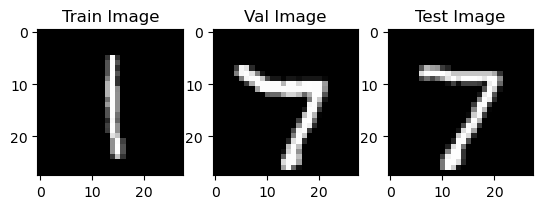

In [187]:
#lets test our datasets (just like we tested our models)

#plot samples from dataset
plt.figure() #creates new empty figure for our plots 
f, axarr = plt.subplots(1, 3) #creates a 1x3 grid of subplots, f is the figure and axarr is an array of axes (subplots) -> one subplot for each train, test, val set. 

train_dataset = MNISTTrain(
    images=train_df.iloc[:, :-1].values.astype(np.uint8), #we drop the last column (labels) and convert to uint8
    labels=train_df['label'].values,
    indices=train_df.index.values
)

#check if len works 
print(len(train_dataset))

#check if getitem works 
print(train_dataset[0])

#show image of data-set 
axarr[0].imshow(train_dataset[0]['image'].squeeze(), cmap='gray')
#note, we know we can access via ['image'] cos we defined it in the dataset class above here: return {'image': image, 'label': label, 'index': index}

axarr[0].set_title(f"Train Image")

print("-"*30)


val_dataset = MNISTVal(
    images=val_df.iloc[:, :-1].values.astype(np.uint8), 
    labels=val_df['label'].values,
    indices=val_df.index.values
)

print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(), cmap='gray')
axarr[1].set_title(f"Val Image")
print("-"*30)


#removed the labels from the test set
test_dataset = MNISTTEst(
    images=test_df.iloc[:, :-1].values.astype(np.uint8), 
    indices=test_df.index.values
)


print(len(test_dataset))
print(test_dataset[0])

axarr[2].imshow(test_dataset[0]['image'].squeeze(), cmap='gray')
axarr[2].set_title(f"Test Image")

## Training Loop


In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [194]:
#Now we get into training loop 
from torch import optim
ADAM_BETAS = (0.9, 0.999)
EPOCHS = 15
#define loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY, betas=ADAM_BETAS)

#lets estimate the time it will take to train the model 
start = timeit.default_timer()


#we add 2 more parameters to the tqdm function: position and leave. 
for epoch in tqdm(range(EPOCHS), position =0, leave=True):
    model.train() #take the model into train mode 
    
    #we need to store train labels and predictions for a given epoch so we can calculate the loss and accuracy for that epoch so we initialise empty lists 
    train_labels = [] 
    train_preds = []
    train_running_loss = 0.0 #store runnign losss which will start at 0
     
    #iterate through data loader 
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        #remember we return 'image' from dataset class and its a dataframe which is accessible like a dictionary
        img = img_label['image'].float().to(device)
        label = img_label['label'].type(torch.uint8).to(device) # remember MNIST labels are always integers between 0–9 (digits) so we store as int
        y_pred = model(img)
        
        #recall the output shape is (batch_size, num_classes) aka ([512, 10]), which is a probability distribution over the 10 classes -> so we need to get the index of the highest probability
        
        
        #to predict the label: 
        y_pred_label = torch.argmax(y_pred, dim=1) #take the column with the highest probability and select it -> dim 1 instead of 0 because we look across the rows of [512, 10] which is the classes
        
        #add to train labels. store to cpu when we can to avoid using up GPU memory 
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        #3 lines below ensure that training is happening 
        
        loss = criterion(y_pred, label) #calculate the loss -> returns a scalar tensor
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward() #backpropagate the loss
        optimizer.step() #update the model parameters
        
        #update the loss 
        train_running_loss += loss.item() #stores the loss for all batches in the epoch
    
    #now we update the train loss for the whole epoch     
    train_loss = train_running_loss / len(train_dataloader) #stores the loss for 1 epoch -> average the loss over the number of batches in the epoch. so we have average loss per batch for 1 epoch. len(train_dataloader) = number of batches in the epoch
    
    
    #calculate train accuracy (num of correct predictions / total num of predictions)
    train_acc = sum(x == y for x, y in zip(train_labels, train_preds)) / len(train_labels)

        
    
    
    #take model into evaluation mode 
    model.eval()
    val_labels = [] #store validation labels for a given epoch 
    val_preds = [] #store validation predictions for a given epoch 
    val_running_loss = 0.0 #store running loss for a given epoch 
    
    #no need to track gradients in validation loop aka ensures no learning is happening in validation loop -> since we just want validation score from trained model 
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label['image'].float().to(device)
            label = img_label['label'].type(torch.uint8).to(device)
            y_pred = model(img)
            
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_dataloader)
    val_acc = sum(x == y for x, y in zip(val_labels, val_preds)) / len(val_labels)

            
     #print as train happens 
    print("-"*30)
    print(f"Train loss EPOCH {epoch+1}: {train_loss:.4f}")       
    print(f"Val loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train acc EPOCH {epoch+1}: {train_acc:.4f}")
    print(f"Val acc EPOCH {epoch+1}: {val_acc:.4f}")
    print("-"*30)
    
stop = timeit.default_timer() 
print(f"Time taken: {stop - start:.2f} seconds")

  7%|▋         | 1/15 [02:00<28:04, 120.29s/it]

------------------------------
Train loss EPOCH 1: 0.1718
Val loss EPOCH 1: 0.1647
Train acc EPOCH 1: 0.9496
Val acc EPOCH 1: 0.9515
------------------------------


 13%|█▎        | 2/15 [06:14<43:06, 198.93s/it]

------------------------------
Train loss EPOCH 2: 0.1634
Val loss EPOCH 2: 0.1576
Train acc EPOCH 2: 0.9516
Val acc EPOCH 2: 0.9547
------------------------------


 20%|██        | 3/15 [08:23<33:26, 167.24s/it]

------------------------------
Train loss EPOCH 3: 0.1519
Val loss EPOCH 3: 0.1553
Train acc EPOCH 3: 0.9555
Val acc EPOCH 3: 0.9530
------------------------------


 27%|██▋       | 4/15 [10:16<26:44, 145.90s/it]

------------------------------
Train loss EPOCH 4: 0.1485
Val loss EPOCH 4: 0.1547
Train acc EPOCH 4: 0.9564
Val acc EPOCH 4: 0.9532
------------------------------


 33%|███▎      | 5/15 [10:58<18:02, 108.28s/it]

------------------------------
Train loss EPOCH 5: 0.1456
Val loss EPOCH 5: 0.1591
Train acc EPOCH 5: 0.9574
Val acc EPOCH 5: 0.9532
------------------------------


 40%|████      | 6/15 [11:42<12:59, 86.57s/it] 

------------------------------
Train loss EPOCH 6: 0.1457
Val loss EPOCH 6: 0.1479
Train acc EPOCH 6: 0.9573
Val acc EPOCH 6: 0.9563
------------------------------


 47%|████▋     | 7/15 [12:43<10:23, 77.96s/it]

------------------------------
Train loss EPOCH 7: 0.1413
Val loss EPOCH 7: 0.1394
Train acc EPOCH 7: 0.9586
Val acc EPOCH 7: 0.9595
------------------------------


 53%|█████▎    | 8/15 [13:30<07:57, 68.21s/it]

------------------------------
Train loss EPOCH 8: 0.1375
Val loss EPOCH 8: 0.1347
Train acc EPOCH 8: 0.9592
Val acc EPOCH 8: 0.9600
------------------------------


 60%|██████    | 9/15 [15:15<07:57, 79.64s/it]

------------------------------
Train loss EPOCH 9: 0.1405
Val loss EPOCH 9: 0.1478
Train acc EPOCH 9: 0.9586
Val acc EPOCH 9: 0.9575
------------------------------


 67%|██████▋   | 10/15 [16:03<05:49, 69.88s/it]

------------------------------
Train loss EPOCH 10: 0.1331
Val loss EPOCH 10: 0.1344
Train acc EPOCH 10: 0.9598
Val acc EPOCH 10: 0.9585
------------------------------


 73%|███████▎  | 11/15 [18:09<05:47, 86.98s/it]

------------------------------
Train loss EPOCH 11: 0.1311
Val loss EPOCH 11: 0.1331
Train acc EPOCH 11: 0.9608
Val acc EPOCH 11: 0.9602
------------------------------


 80%|████████  | 12/15 [19:49<04:33, 91.20s/it]

------------------------------
Train loss EPOCH 12: 0.1296
Val loss EPOCH 12: 0.1309
Train acc EPOCH 12: 0.9610
Val acc EPOCH 12: 0.9613
------------------------------


 87%|████████▋ | 13/15 [20:29<02:31, 75.69s/it]

------------------------------
Train loss EPOCH 13: 0.1237
Val loss EPOCH 13: 0.1356
Train acc EPOCH 13: 0.9631
Val acc EPOCH 13: 0.9582
------------------------------


 93%|█████████▎| 14/15 [21:06<01:03, 63.83s/it]

------------------------------
Train loss EPOCH 14: 0.1255
Val loss EPOCH 14: 0.1340
Train acc EPOCH 14: 0.9620
Val acc EPOCH 14: 0.9590
------------------------------


100%|██████████| 15/15 [21:48<00:00, 87.24s/it]

------------------------------
Train loss EPOCH 15: 0.1231
Val loss EPOCH 15: 0.1305
Train acc EPOCH 15: 0.9627
Val acc EPOCH 15: 0.9608
------------------------------
Time taken: 1308.62 seconds


In [ ]:
#TODO:save model to file

torch.save(model.state_dict(), f"./models/train_one_weights.pth")

In [233]:
test_iter = iter(test_loader)
test_pictures, test_true_values = next(test_iter)

True Value: 5


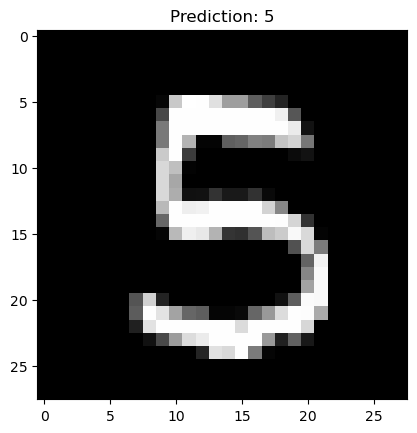

True Value: 2


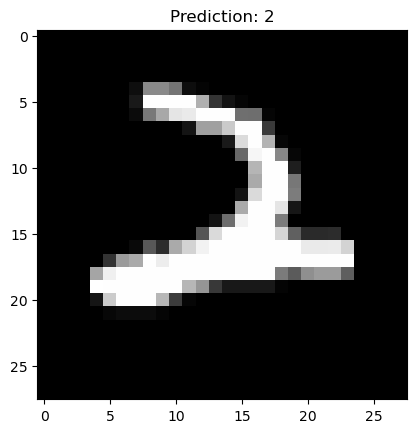

True Value: 6


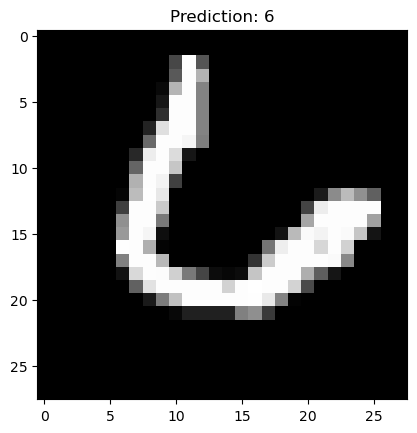

True Value: 1


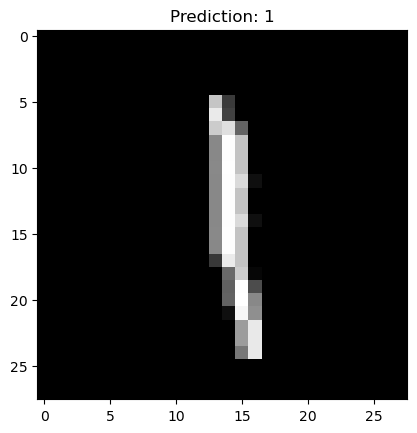

True Value: 2


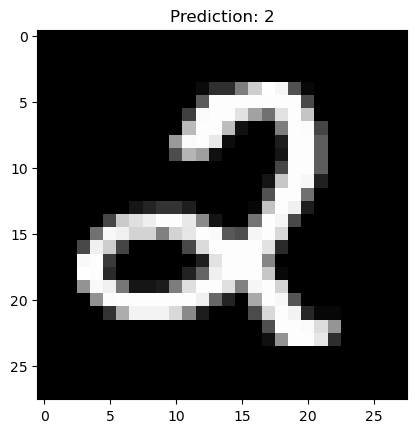

In [237]:
infer_transform = transforms.Compose(
        [
        # transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])
def model_infer(image):
    image = infer_transform(image).unsqueeze(0).to('cuda')
    with torch.no_grad():
        out = model(image)
        # print(f"out is ==> {out}")
    out = out.argmax(dim=1).item()
    return out

for index in range(5):
    plt.imshow(test_pictures[index].squeeze(), cmap='gray')
    plt.title(f"Prediction: {model_infer(test_pictures[index])}")
    print(f"True Value: {test_true_values[index]}")
    plt.show()